# Apply Albumentations Perturbations with NRTK

This simple notebook demonstrates how to use Albumentations perturbers in an NRTK context, we use a sample image from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset.

Documentation on the available perturbers and their parameters can be found on the [documentation for the Albumentations module](https://albumentations.ai/docs/examples/example-weather-transforms/)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/albumentations_perturber.ipynb)


## Set Up the Environment
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).


Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Installing albumentations...")
!{sys.executable} -m pip install -q albumentations
print("Done!")

Installing nrtk...
Installing matplotlib...
Installing headless OpenCV...
Installing albumentations...
Done!


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import urllib.request
from typing import TYPE_CHECKING

import numpy as np
from matplotlib import patches
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

from nrtk.impls.perturb.wrapper.albumentations_perturber import AlbumentationsPerturber

## Select Initial Image
We'll carry out perturbations on a single image from VisDrone.

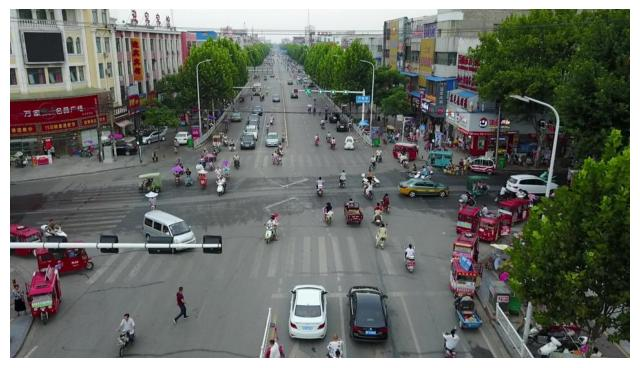

In [4]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8, 8))
plt.axis("off")
_ = plt.imshow(img)

We'll also define a helper functions for displaying our perturbations.

In [ ]:
def display_pert(img: np.ndarray, descriptor: str = "", bbox: AxisAlignedBoundingBox | None = None) -> None:
    """Display perturbation."""
    _, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert isinstance(axs, Axes)
    if bbox:
        rect = patches.Rectangle(
            (bbox.min_vertex[0], bbox.min_vertex[1]),
            bbox.max_vertex[0] - bbox.min_vertex[0],
            bbox.max_vertex[1] - bbox.min_vertex[1],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        axs.add_patch(rect)
    axs.set_title(descriptor)
    axs.imshow(img)

    axs.axis("off")

### RandomRain

> This transform simulates rainfall by overlaying semi-transparent streaks onto the image,
  creating a realistic rain effect. It can be used to augment datasets for computer vision
  tasks that need to perform well in rainy conditions.

Note the arguments to `AlbumentationsPerturber`:
- `perturber`: Name of the class which extends `BasicTransform`
- `parameters`: Parameters to the constructor of the chosen `perturber`
- `seed`: Optional. Sets a seed for random elements of the perturber for reproducibility

Note that `paramters["p"]` represents a probability of the perturbation occuring and is `0.5` by default.
To ensure the transform occurs, included `"p": 1.0` in `paramters`.

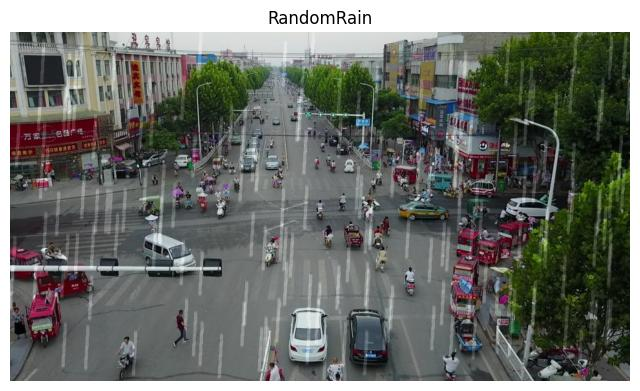

In [6]:
parameters = {"brightness_coefficient": 0.9, "drop_width": 1, "blur_value": 5, "p": 1.0}
perturber = AlbumentationsPerturber(perturber="RandomRain", parameters=parameters, seed=7)
img_out, _ = perturber(img)
display_pert(img_out, "RandomRain")

### RandomFog
> Simulates fog for the image by adding random fog-like artifacts.
This transform creates a fog effect by generating semi-transparent overlays
that mimic the visual characteristics of fog. The fog intensity and distribution
can be controlled to create various fog-like conditions.

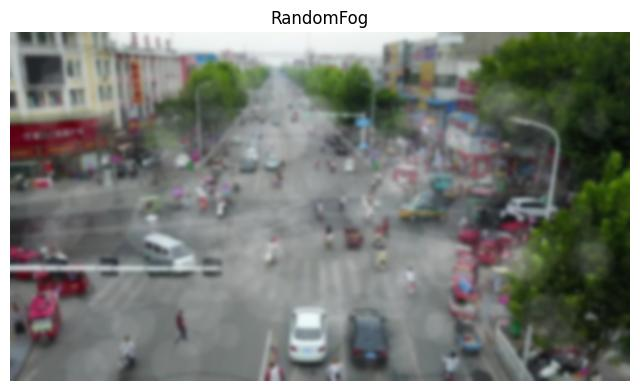

In [7]:
parameters = {"fog_coef_range": (0.7, 0.8), "alpha_coef": 0.1, "p": 1.0}
perturber = AlbumentationsPerturber(perturber="RandomFog", parameters=parameters, seed=7)
img_out, _ = perturber(img)
display_pert(img_out, "RandomFog")

### RandomSnow

> This transform simulates snowfall by either bleaching out some pixel values

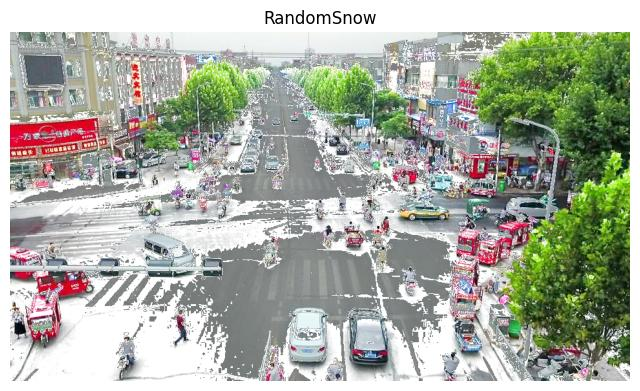

In [8]:
parameters = {"snow_point_range": (0.2, 0.4), "brightness_coeff": 2.5, "p": 1.0}

perturber = AlbumentationsPerturber(perturber="RandomSnow", parameters=parameters, seed=7)
img_out, _ = perturber(img)
display_pert(img_out, "RandomSnow")

### RandomSunFlare

> Simulates a sun flare effect on the image by adding circles of light.
> This transform creates a sun flare effect by overlaying multiple semi-transparent
> circles of varying sizes and intensities along a line originating from a "sun" point.


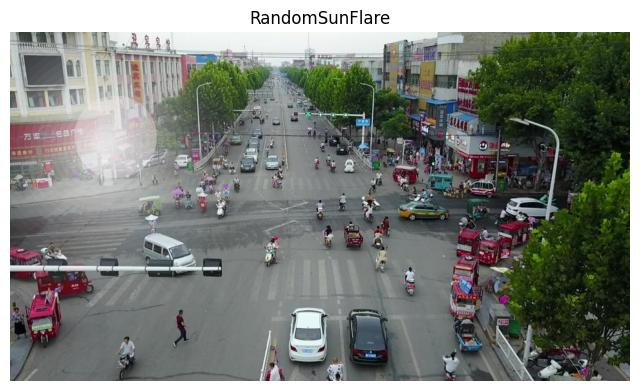

In [9]:
parameters = {"flare_roi": (0, 0, 1, 0.5), "angle_range": (0.25, 0.75), "p": 1.0}

perturber = AlbumentationsPerturber(perturber="RandomSunFlare", parameters=parameters, seed=7)
img_out, _ = perturber(img)
display_pert(img_out, "RandomSunFlare")

## Bounding Boxes

The following example performs a `HorizontalFlip` in order to demonstrate how bounding boxes are updated by a transform.

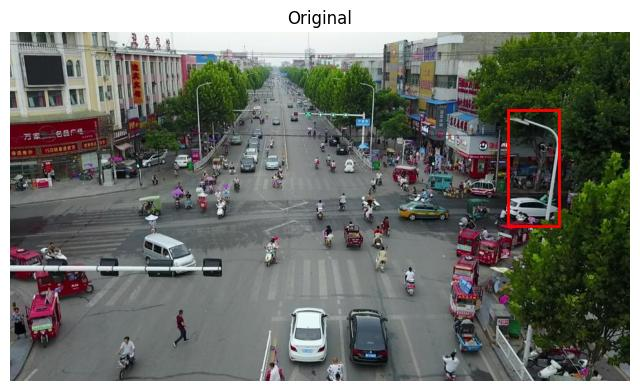

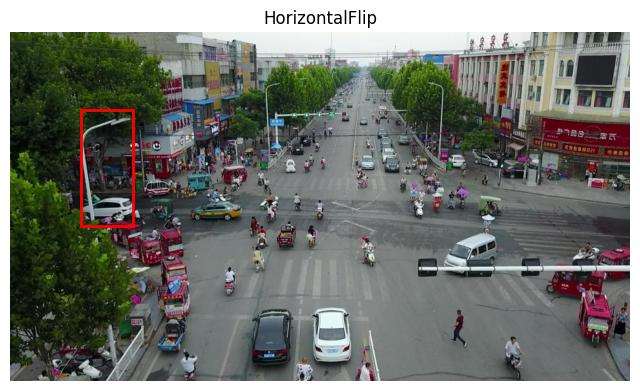

In [10]:
conf_dict = dict()
conf_dict["label"] = 1.0
bboxes = [(AxisAlignedBoundingBox((770, 120), (850, 300)), conf_dict)]
perturber = AlbumentationsPerturber(perturber="HorizontalFlip", parameters={"p": 1})
img_out, output_bboxes = perturber(img, bboxes)
display_pert(img, "Original", bbox=bboxes[0][0])
if output_bboxes:
    op_bboxes = list(output_bboxes)[0][0]
    display_pert(img_out, "HorizontalFlip", bbox=op_bboxes)